In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
import pandas as pd
import os


def parallel_matrix_multiplication(A, B, num_cpus):

    with ThreadPoolExecutor(max_workers=num_cpus) as executor:
        futures = []
        for i in range(len(A)):
            futures.append(executor.submit(np.matmul, A[i], B))
        results = [f.result() for f in concurrent.futures.as_completed(futures)]
    return np.array(results)
 

def print_test_and_result(A, B, num_cpus ):
    computed_result = parallel_matrix_multiplication(A, B, num_cpus)
    correct_results = np.matmul(A, B)
    if not np.allclose(computed_result, correct_results):
        print(f"Difference in results the correct result is: \n {correct_results} \n\n computed result: with {num_cpus} CPUS \n {computed_result} ")
    else:
        print(f"correct result with {num_cpus}")

A_tests = [
    np.array([[0, 0, 0], [1, 1, 1], [1, 1, 1]]),
    np.array([[1, 1, 1], [2, 2, 2], [0, 0, 0]]),
    np.array([[0, 0, 0], [2, 2, 2], [0, 0, 0]]),
    np.array([[0, 1, 0], [0, 1, 0], [0, -1, 0]])
]

B_test = np.array([[2, 2, 2], [1, 1, 1], [0, 0, 0]])

correct_results = [
    np.array([[0, 0, 0], [3, 3, 3], [3, 3, 3]]),
    np.array([[3, 3, 3], [6, 6, 6], [0, 0, 0]]),
    np.array([[0, 0, 0], [6, 6, 6], [0, 0, 0]]),
    np.array([[1, 1, 1], [1, 1, 1], [-1, -1, -1]])
]
# Number of CPU cores to use
num_cpus = [1, 2, 4, 8]
for i, A in enumerate(A_tests):
    for num_cpu in num_cpus:
        print_test_and_result(A_tests[i], B_test,num_cpu)






correct result with 1
Difference in results the correct result is: 
 [[0 0 0]
 [3 3 3]
 [3 3 3]] 

 computed result: with 2 CPUS 
 [[3 3 3]
 [0 0 0]
 [3 3 3]] 
Difference in results the correct result is: 
 [[0 0 0]
 [3 3 3]
 [3 3 3]] 

 computed result: with 4 CPUS 
 [[3 3 3]
 [0 0 0]
 [3 3 3]] 
Difference in results the correct result is: 
 [[0 0 0]
 [3 3 3]
 [3 3 3]] 

 computed result: with 8 CPUS 
 [[3 3 3]
 [3 3 3]
 [0 0 0]] 
correct result with 1
Difference in results the correct result is: 
 [[3 3 3]
 [6 6 6]
 [0 0 0]] 

 computed result: with 2 CPUS 
 [[6 6 6]
 [3 3 3]
 [0 0 0]] 
Difference in results the correct result is: 
 [[3 3 3]
 [6 6 6]
 [0 0 0]] 

 computed result: with 4 CPUS 
 [[6 6 6]
 [0 0 0]
 [3 3 3]] 
Difference in results the correct result is: 
 [[3 3 3]
 [6 6 6]
 [0 0 0]] 

 computed result: with 8 CPUS 
 [[6 6 6]
 [3 3 3]
 [0 0 0]] 
correct result with 1
Difference in results the correct result is: 
 [[0 0 0]
 [6 6 6]
 [0 0 0]] 

 computed result: with 2 CPUS

In [2]:
import mkl
current_threads = mkl.get_max_threads()
print(current_threads)
mkl.set_num_threads(1)
current_threads = mkl.get_max_threads()
print(current_threads)
import numpy as np
import time
from concurrent.futures import ThreadPoolExecutor


num_cpus = [1,2, 4, 8, 10, 16] 
print(num_cpus[:4])
print(num_cpus[4:])
    # If needed, results can now be used for further analysis or plotting


ModuleNotFoundError: No module named 'mkl'

In [ ]:
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import threading
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

num_threads = os.cpu_count()

def print_test_and_result(computed_result, correct_results):
    if not np.allclose(computed_result, correct_results):
        print(f"Difference in results the correct result is: \n {correct_results} \n\n computed result: with {num_cpus} CPUS \n {computed_result} ")

def split_matrix_into_blocks(arr, rows_per_block, cols_per_block):
    """
    Split arr into smaller blocks of shape (rows_per_block, cols_per_block).
    Each block is a view into the original array to preserve memory efficiency.
    """
    h, w = arr.shape
    n, m = h // rows_per_block, w // cols_per_block
    return arr.reshape(rows_per_block, n, cols_per_block, m).swapaxes(1, 2)

def mydot(a, b, rows_per_cpu, cols_per_cpu, dot_func=np.matmul):
    """
    Compute the matrix product a * b in parallel, splitting the work into blocks 
    processed by simulated CPUs.
    """
    total_cpus = rows_per_cpu * cols_per_cpu
    out = np.empty((a.shape[0], b.shape[1]), dtype=a.dtype)
    out_blocks = split_matrix_into_blocks(out, rows_per_cpu, cols_per_cpu)
    a_blocks = split_matrix_into_blocks(a, rows_per_cpu, 1)
    b_blocks = split_matrix_into_blocks(b, 1, cols_per_cpu)

    cpu_threads = []
    for i in range(rows_per_cpu):
        for j in range(cols_per_cpu):
            thread = threading.Thread(target=dot_func, 
                                      args=(a_blocks[i, 0, :, :], 
                                            b_blocks[0, j, :, :], 
                                            out_blocks[i, j, :, :]))
            thread.start()
            cpu_threads.append(thread)

    for thread in cpu_threads:
        thread.join()

    return out

def parallel_matrix_multiplication(A, B, num_cpus):
    config = {1: (1, 1), 2: (1, 2), 4: (2, 2), 6: (2, 3), 8: (2, 4), 10: (2, 5), 12: (2, 6), 16: (4,4)}
    rows_per_cpu, cols_per_cpu = config.get(num_cpus, (1, 1))
    return mydot(A, B, rows_per_cpu, cols_per_cpu)

matrix_sizes = [3200,3600,4000,4400,5000,6000,7000,8000]
num_cpus = [1,2, 4, 8, 10, 16]  # Adjust based on your machine's capability
matrix_sizes2 = [100,200,400,800,1000,1200,1400,1600,2000,3000]
sequential_times = np.zeros((len(matrix_sizes), 1))
parallel_times = np.zeros((len(matrix_sizes), len(num_cpus)))
speed_ups = np.zeros((len(matrix_sizes), len(num_cpus)))

# Measure execution times and calculate speed-up
epsilon = 1e-9  # Small number to prevent division by zero
data = []
# Modified function to accept `num_cpus` as an argument
def matrix_multiply(size, num_cpus):
    restults = {}
    np.random.seed()  # Ensure different random matrices for each size
    A = np.random.randn(size, size).astype(np.int16)
    B = np.random.randn(size, size).astype(np.int16)
    if num_cpus > 1:
        start_time = time.perf_counter() 
        mkl.set_num_threads(num_cpus)  # Set MKL to use specified number of threads
        parrallel = parallel_matrix_multiplication(A, B, num_cpus)
        execution_time = time.perf_counter()  - start_time
        print(f'Time: {execution_time} for array size {size} x {size} with {num_cpus}')
        results = {'size': size, 'cpus': num_cpus, 'time': execution_time}
        data.append({'size': size, 'cpus': num_cpus, 'time': execution_time})
    else:
        
        start_time = time.perf_counter() 
        np.matmul(A, B)
        execution_time = time.perf_counter()  - start_time
        print(f'Time: {execution_time} for array size {size} x {size} with {num_cpus}')
        data.append({'size': size, 'cpus': num_cpus, 'time': execution_time})
        results = {'size': size, 'cpus': num_cpus, 'time': execution_time}
    return results

# Function to run matrix multiplications in parallel with specified `num_cpus`
def run_parallel_matrix_multiplications(num_cpus,matrix_sizes):
    # Calculate the number of jobs to run in parallel based on the number of CPUs per task
    # Assuming you have a total of 16 CPUs available
    total_cpus_available = 16
    
    max_workers = 18 

    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(matrix_multiply, size, num_cpus) for size in matrix_sizes]
        for future in futures:
            result = future.result()
            results.append(result)
           
    df = pd.DataFrame(results)
    df.to_csv("testresults.csv", mode='a', header=False, index=False)
  
            
    

first_data = []
if __name__ == '__main__':
    for  cpus in num_cpus:
        run_parallel_matrix_multiplications(cpus,matrix_sizes2)
    for cpus in num_cpus:
        run_parallel_matrix_multiplications(cpus,matrix_sizes)



Time: 0.0011850000000208638 for array size 100 x 100 with 1
Time: 0.011518800000033025 for array size 200 x 200 with 1
Time: 0.0926640000000134 for array size 400 x 400 with 1
Time: 0.7886786999999913 for array size 800 x 800 with 1
Time: 1.5325616999999738 for array size 1000 x 1000 with 1
Time: 2.643203099999994 for array size 1200 x 1200 with 1
Time: 4.3492367999999715 for array size 1400 x 1400 with 1
Time: 6.443543499999976 for array size 1600 x 1600 with 1
Time: 12.100879099999986 for array size 2000 x 2000 with 1
Time: 64.9979932 for array size 3000 x 3000 with 1
Time: 0.0017030999999860796 for array size 100 x 100 with 2
Time: 0.007550699999967492 for array size 200 x 200 with 2
Time: 0.0473372000000154 for array size 400 x 400 with 2
Time: 0.4064453999999955 for array size 800 x 800 with 2
Time: 0.8593692000000033 for array size 1000 x 1000 with 2
Time: 1.4812758999999573 for array size 1200 x 1200 with 2
Time: 2.455412000000024 for array size 1400 x 1400 with 2
Time: 3.553731

   size  cpus      time
0   100     1  0.001859
1   200     1  0.016932
2   400     1  0.090425
3   800     1  0.801996
4  1000     1  1.572478
cpus
1     635
2     604
4     572
8     572
10    563
16    563
dtype: int64
cpus  size
1     100     63
      200     63
      400     63
      600     43
      800     63
      1000    62
      1200    62
      1400    62
      1600    26
      2000    26
      2600    13
      3000    19
      3600    14
      4000    14
      5000    14
      6000    14
      7000    14
2     100     61
      200     61
      400     61
      600     43
      800     61
      1000    60
      1200    60
      1400    60
      1600    24
      2000    24
      2600    12
      3000    17
      3600    12
      4000    12
      5000    12
      6000    12
      7000    12
4     100     59
      200     59
      400     59
      600     43
      800     59
      1000    58
      1200    58
      1400    58
      1600    22
      2000    22
      2600    10
  

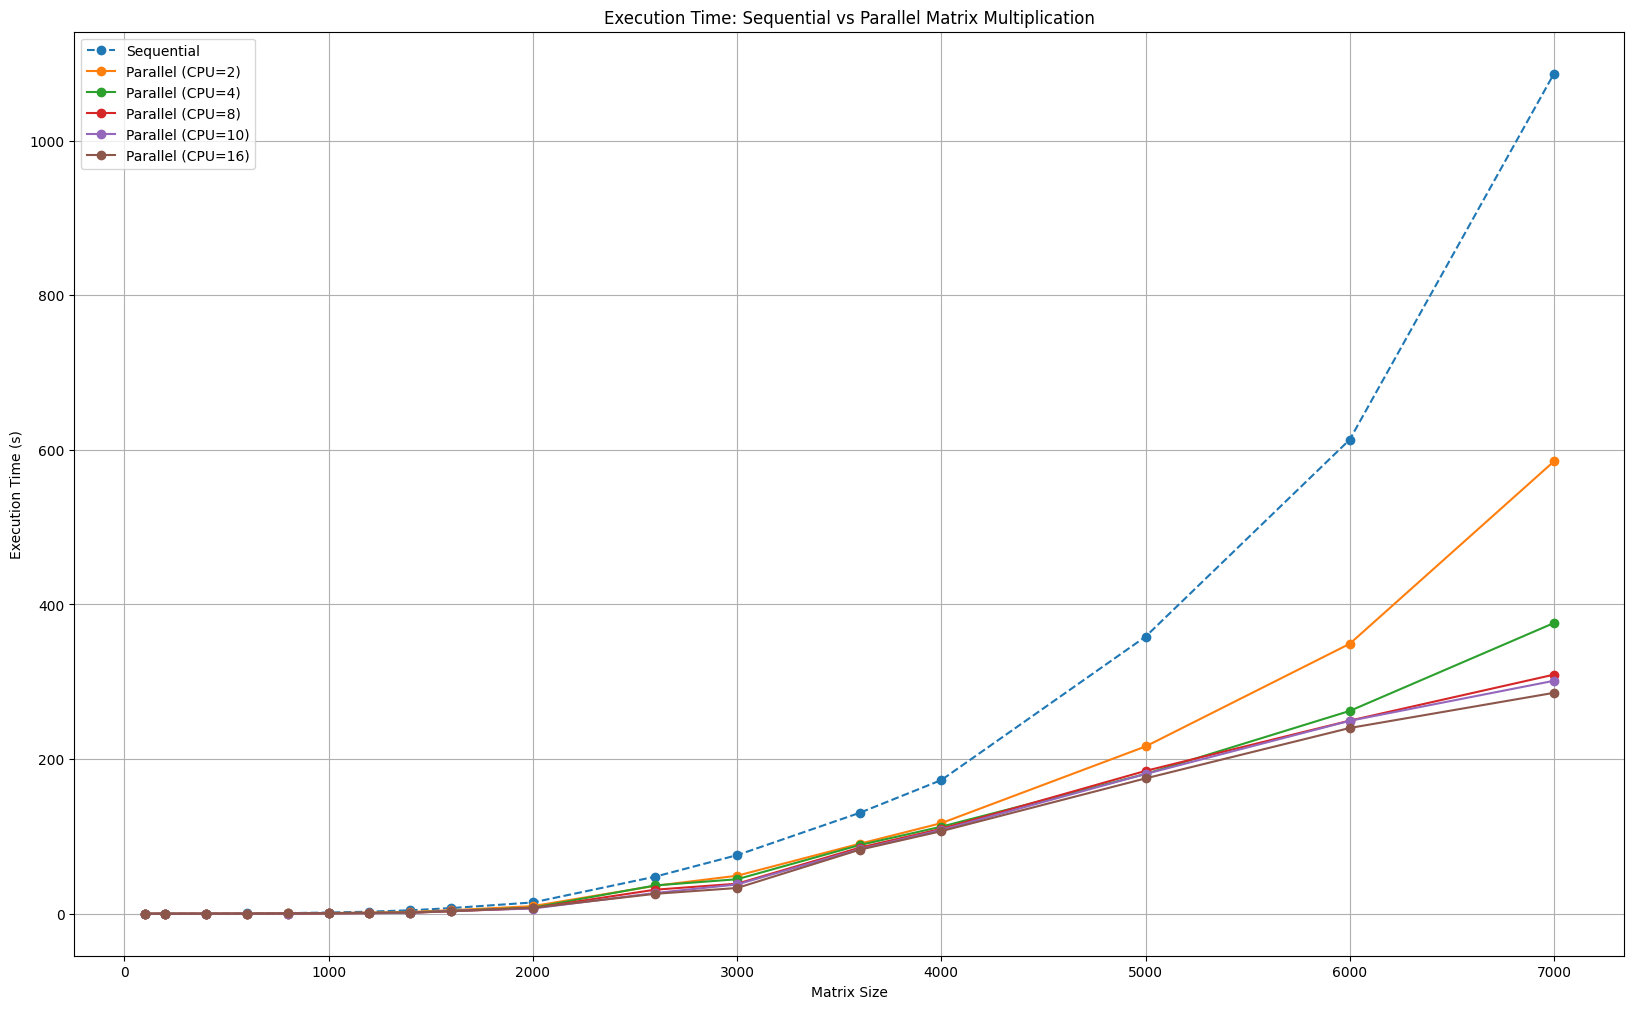

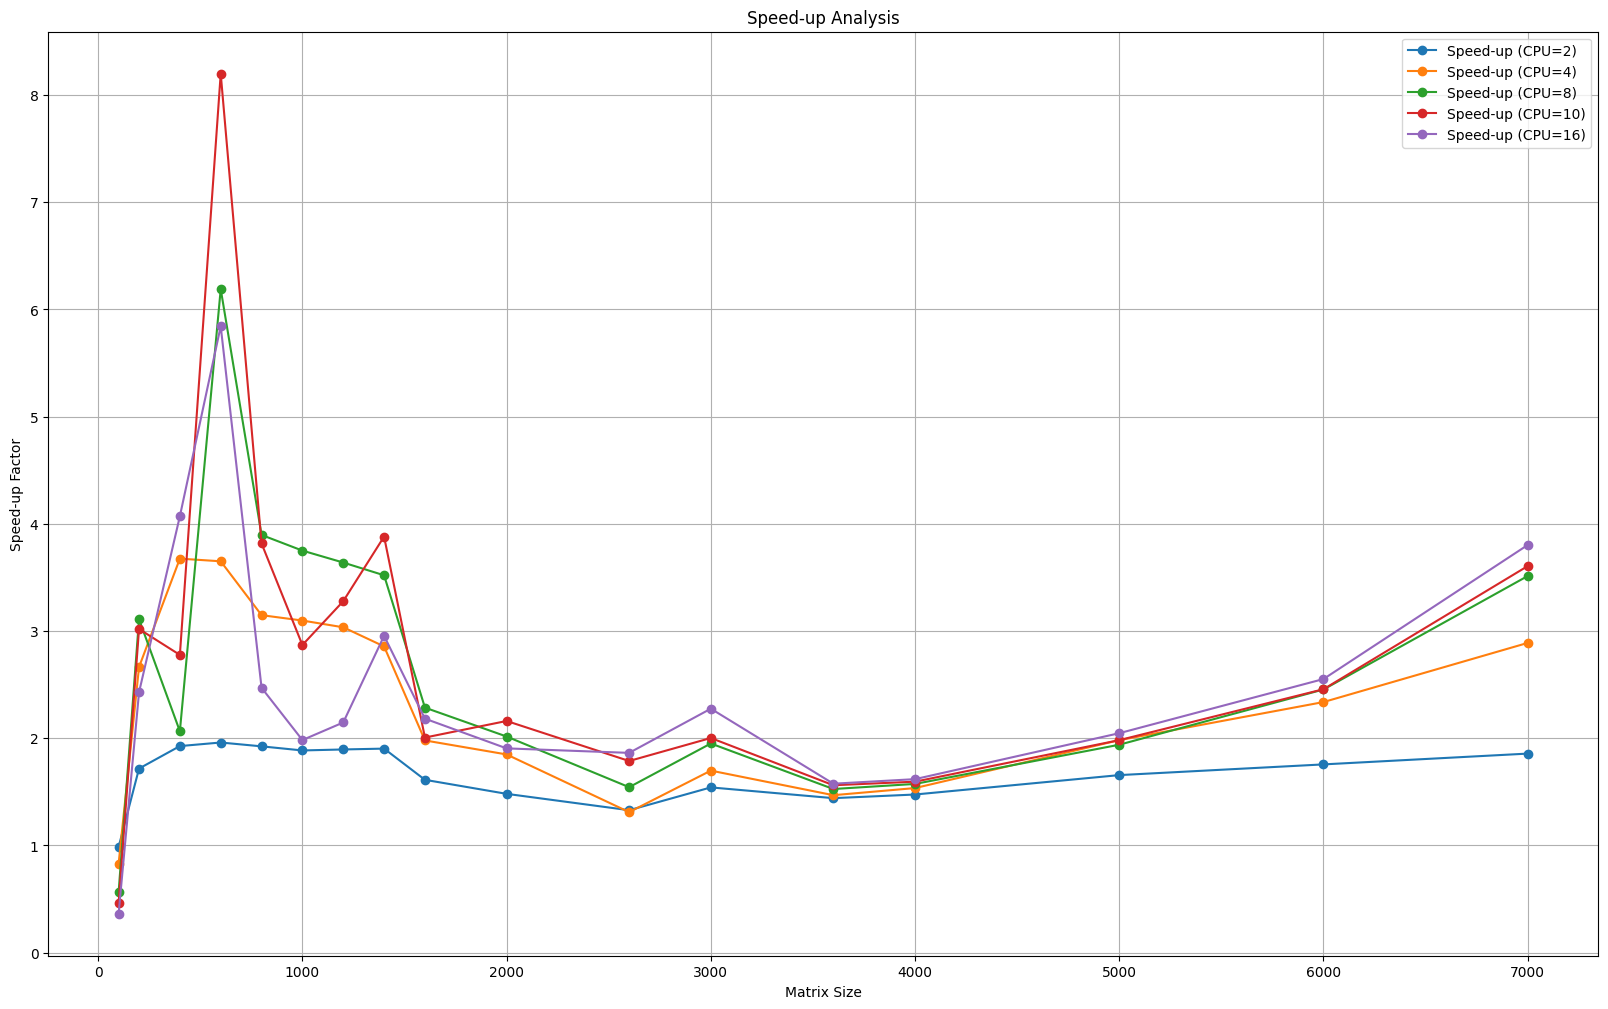

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
file_path = 'C:\\Users\\spocam\\Desktop\\testresults.csv'

df = pd.read_csv(file_path)
# Display the first few rows to verify it's loaded correctly
print(df.head())

# Separate the sequential times
sequential_times = df[df['cpus'] == 1]

sequential_times = df[df['cpus'] == 1][['size', 'time']].rename(columns={'time': 'time_seq'})

# Filter the data to include cpus up to 16 and sizes up to 7000
data = df 
filtered_data = data[(data['cpus'] <= 16) & (data['size'] <= 7000)]

# Calculate the average time grouped by both 'cpus' and 'size'
average_time_by_cpus_and_size = filtered_data.groupby(['cpus', 'size'])['time'].mean()
cpu_counts = filtered_data.groupby('cpus').size()
counts_by_size_and_cpu = filtered_data.groupby(['cpus', 'size']).size()
print(cpu_counts)
print(counts_by_size_and_cpu)

df = average_time_by_cpus_and_size.reset_index()

# Merge sequential times back to the main DataFrame to calculate speedup
df = df.merge(sequential_times, on='size', how='left')


# Calculate speedup by dividing sequential time by parallel time
df['speedup'] = df['time_seq'] / df['time']
# Unique matrix sizes and CPU counts
cpu_counts = sorted(df['cpus'].unique())

# Plotting execution time
plt.figure(figsize=(20, 12))
for cpu in cpu_counts:
    # Get the mean time for each matrix size and this cpu count
    grouped_data = df[df['cpus'] == cpu].groupby('size')['time'].mean()
    if cpu == 1:
        plt.plot(grouped_data.index, grouped_data, label=f'Sequential', linestyle='--', marker='o')
    else:
        plt.plot(grouped_data.index, grouped_data, label=f'Parallel (CPU={cpu})', marker='o')

plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time: Sequential vs Parallel Matrix Multiplication')
plt.legend()
plt.grid(True)
plt.show()

# Plotting speed-up
plt.figure(figsize=(20, 12))
for cpu in cpu_counts:
    if cpu > 1:
        # Get the mean speedup for each matrix size and this cpu count
        grouped_data = df[df['cpus'] == cpu].groupby('size')['speedup'].mean()
        plt.plot(grouped_data.index, grouped_data, label=f'Speed-up (CPU={cpu})', marker='o')

plt.xlabel('Matrix Size')
plt.ylabel('Speed-up Factor')
plt.title('Speed-up Analysis')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
cpu_counts = filtered_data.groupby('cpus').size()
counts_by_size_and_cpu = filtered_data.groupby('size').size()
pd.set_option('display.max_rows', None)  # Or set it to a high number you think will cover all rows

print(cpu_counts)
print(counts_by_size_and_cpu)

cpus
1     637
2     604
4     572
8     572
10    563
16    563
dtype: int64
size
100     358
200     358
400     358
600     258
800     358
1000    352
1200    352
1400    352
1600    136
2000    136
2600     65
3000     96
3200      1
3600     66
4000     66
4400      1
5000     66
6000     66
7000     66
dtype: int64


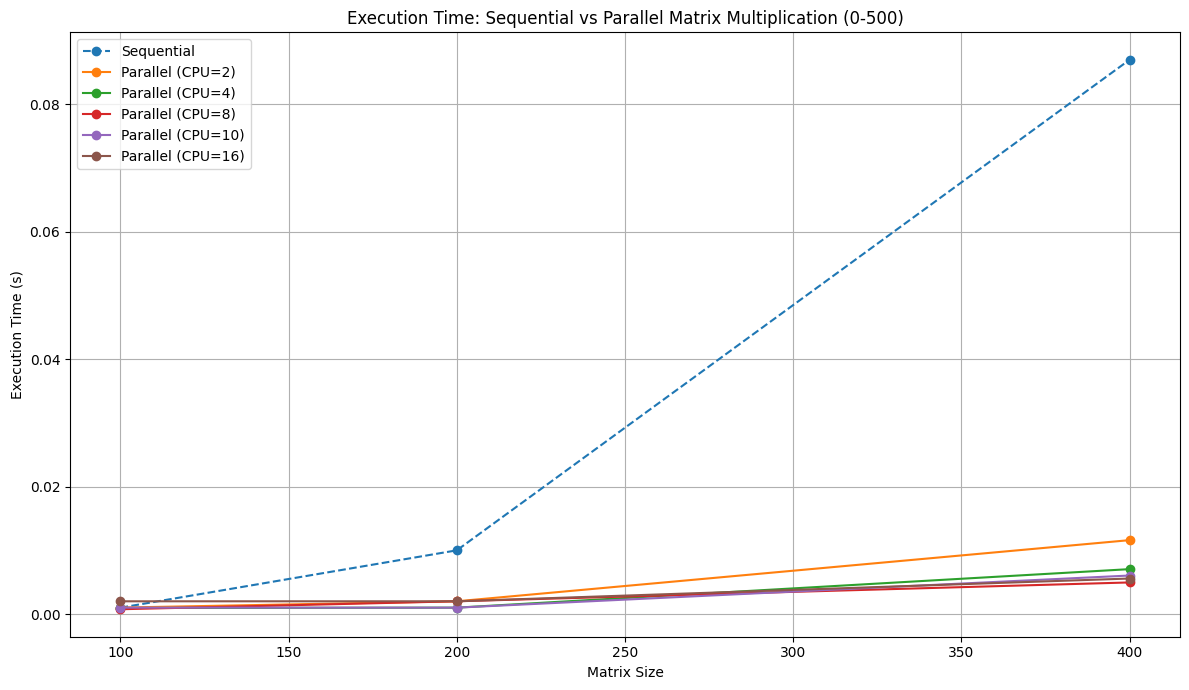

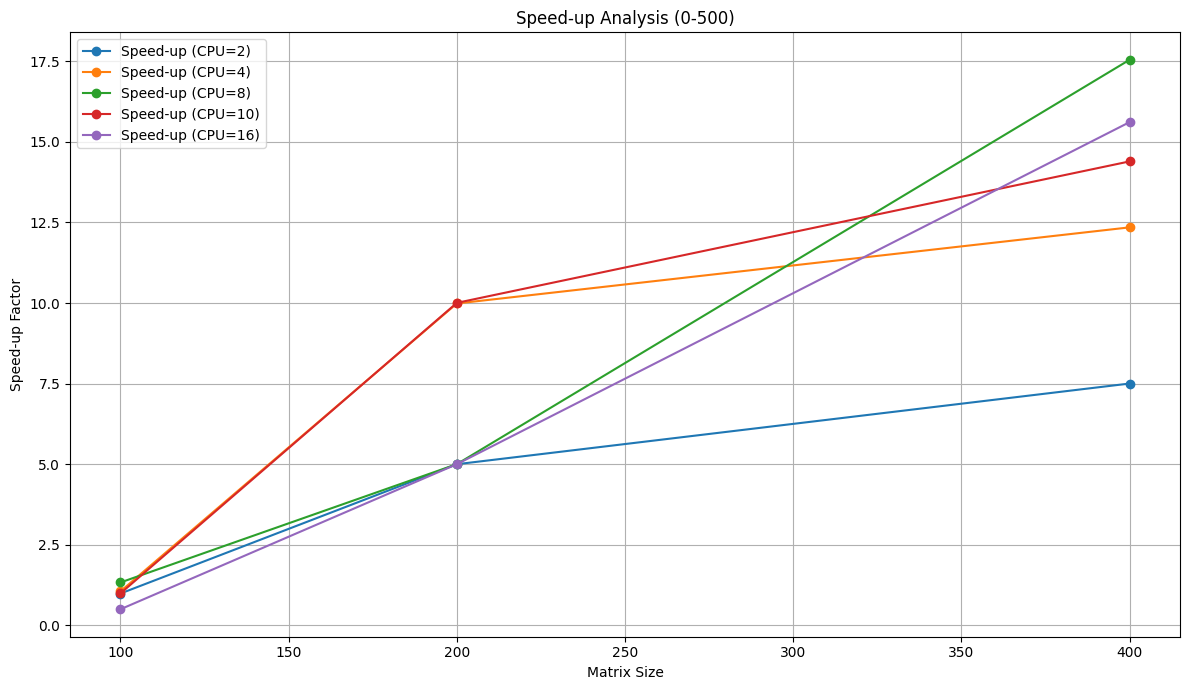

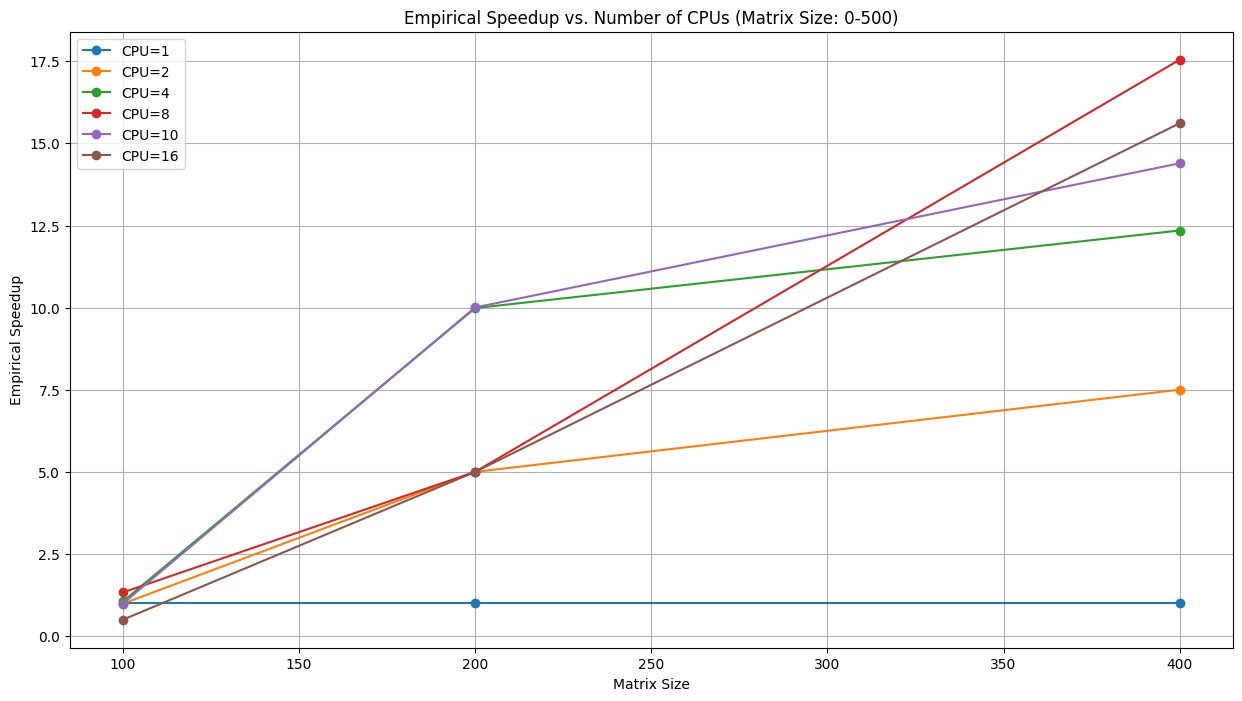

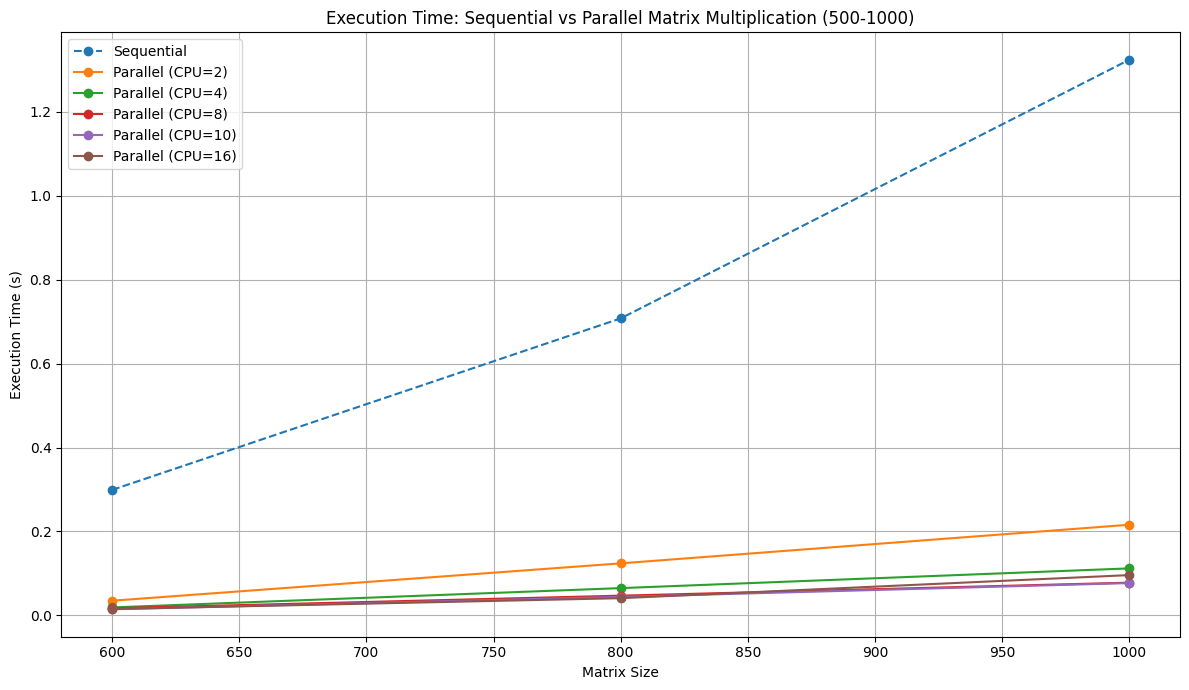

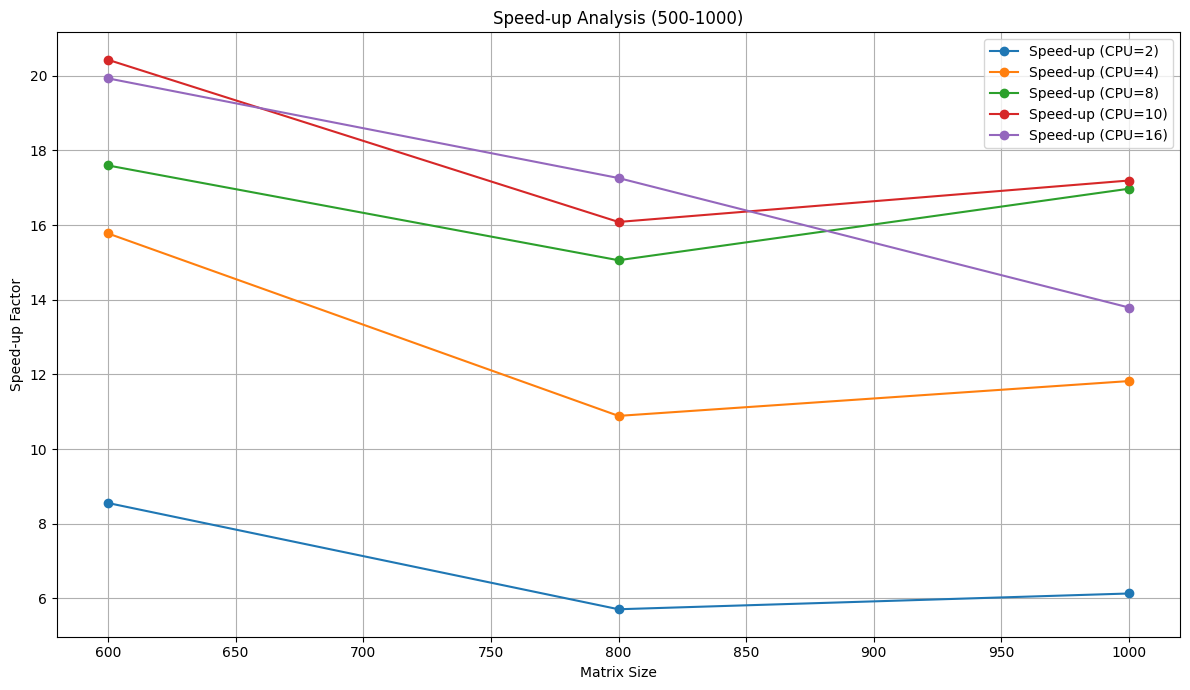

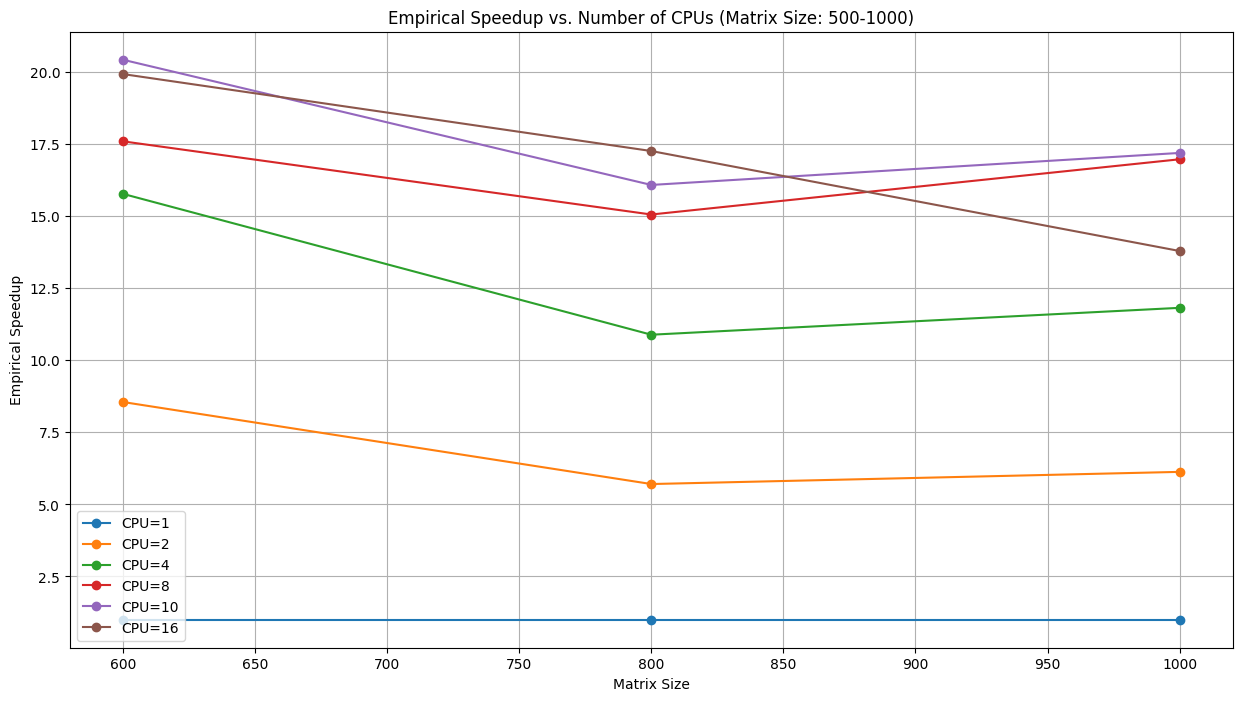

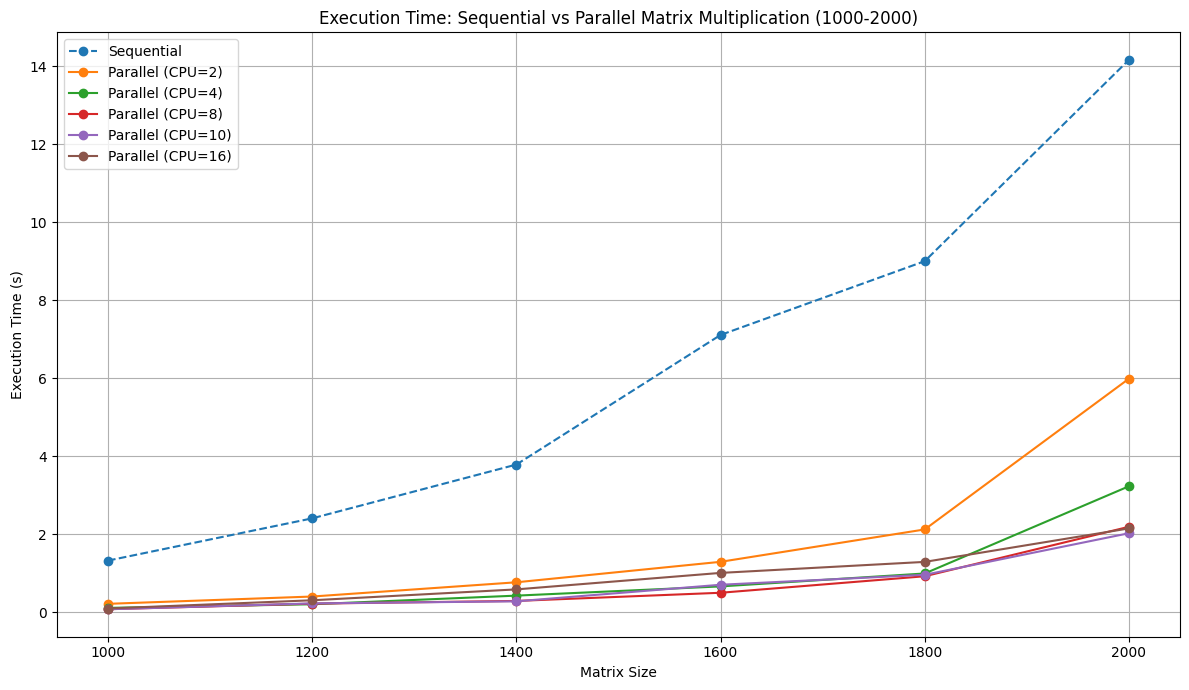

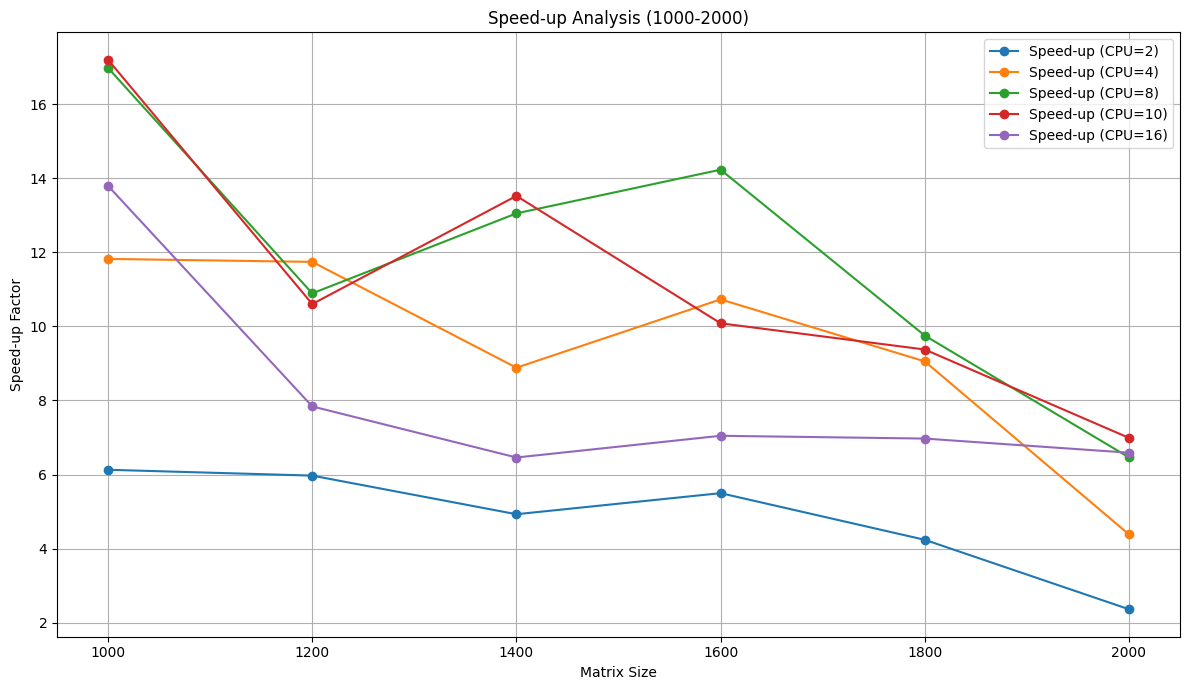

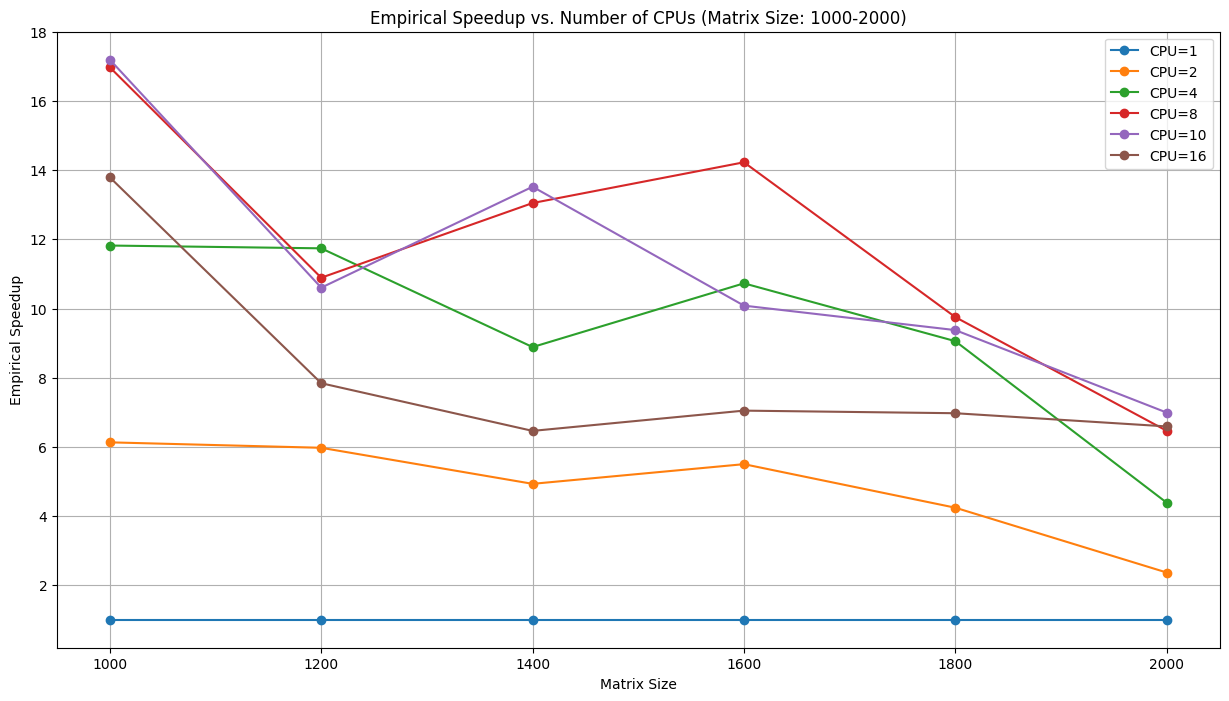

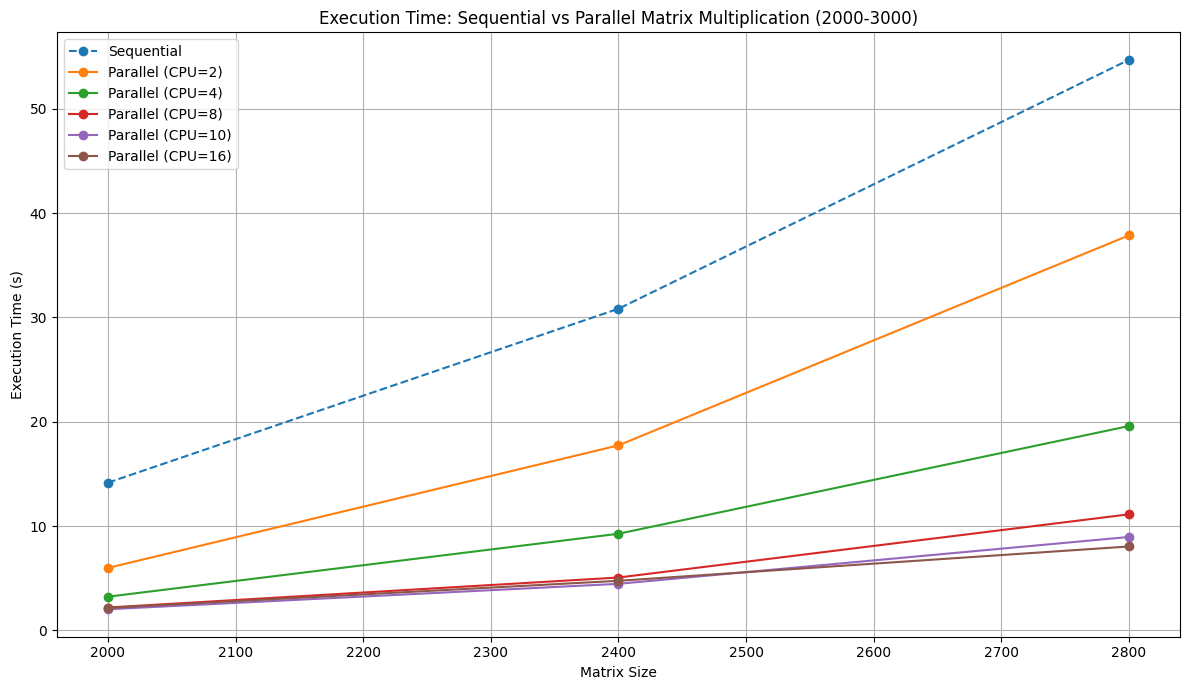

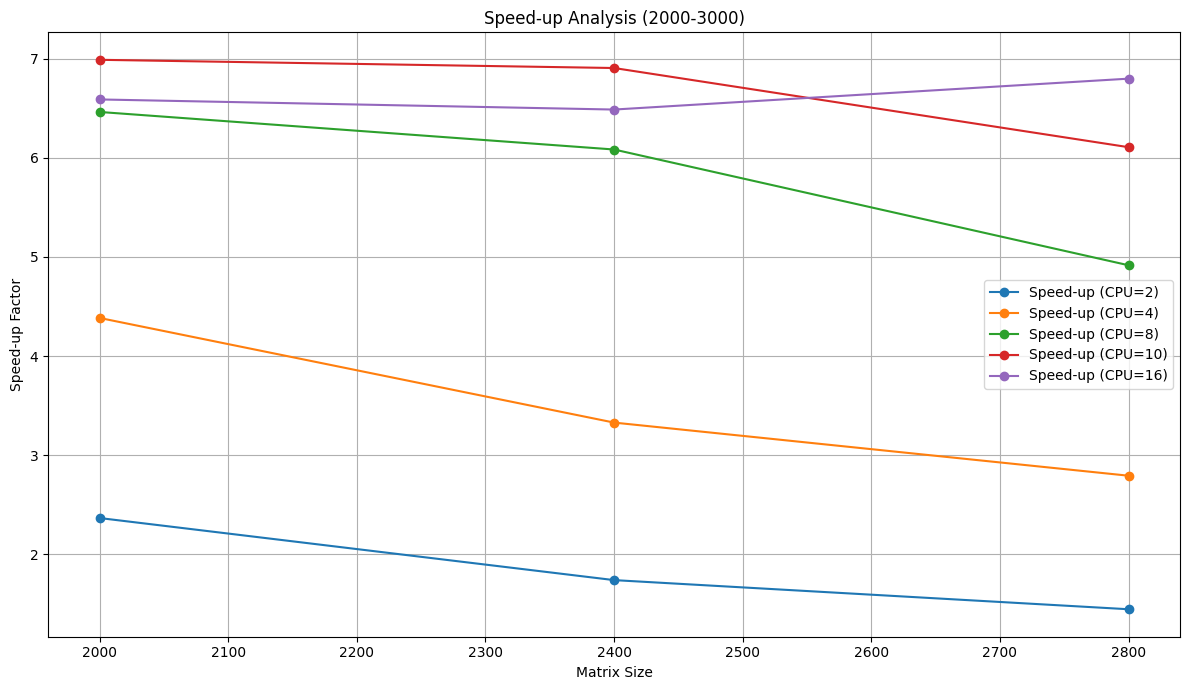

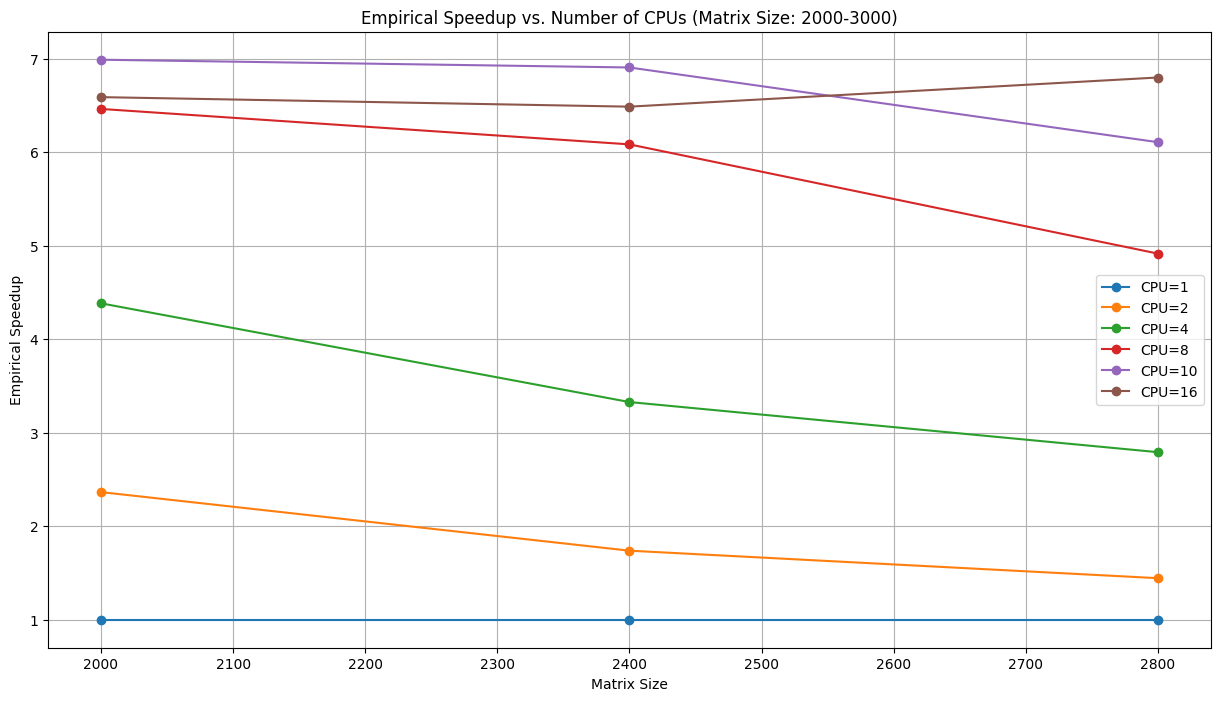

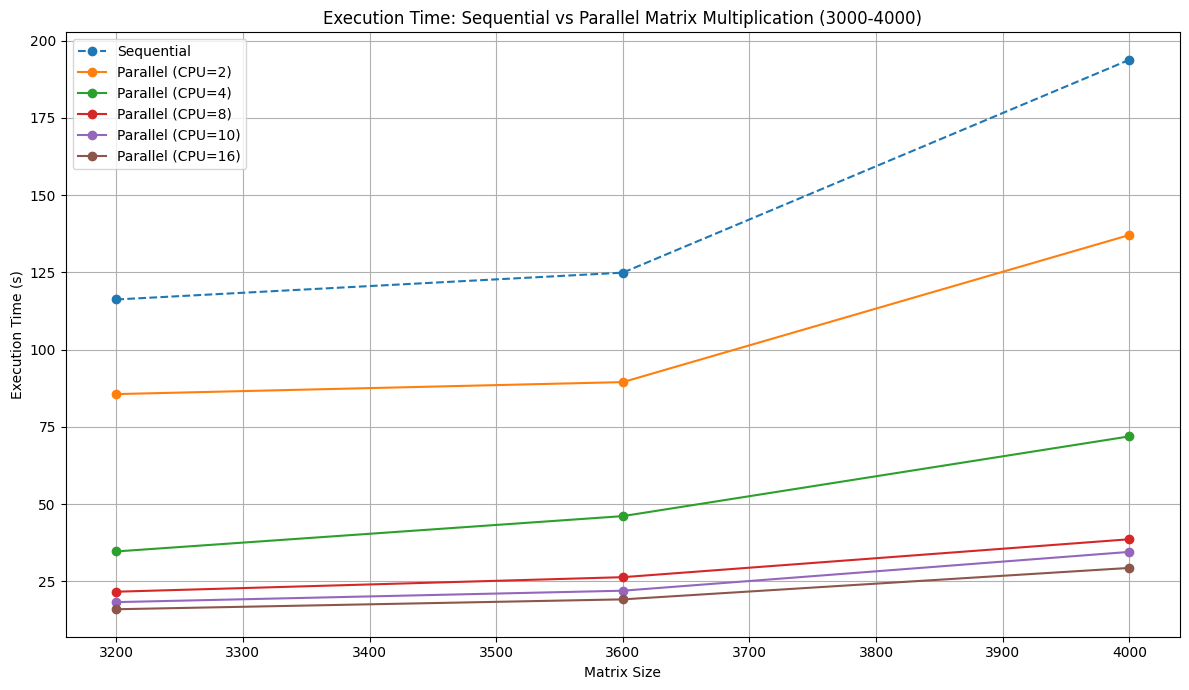

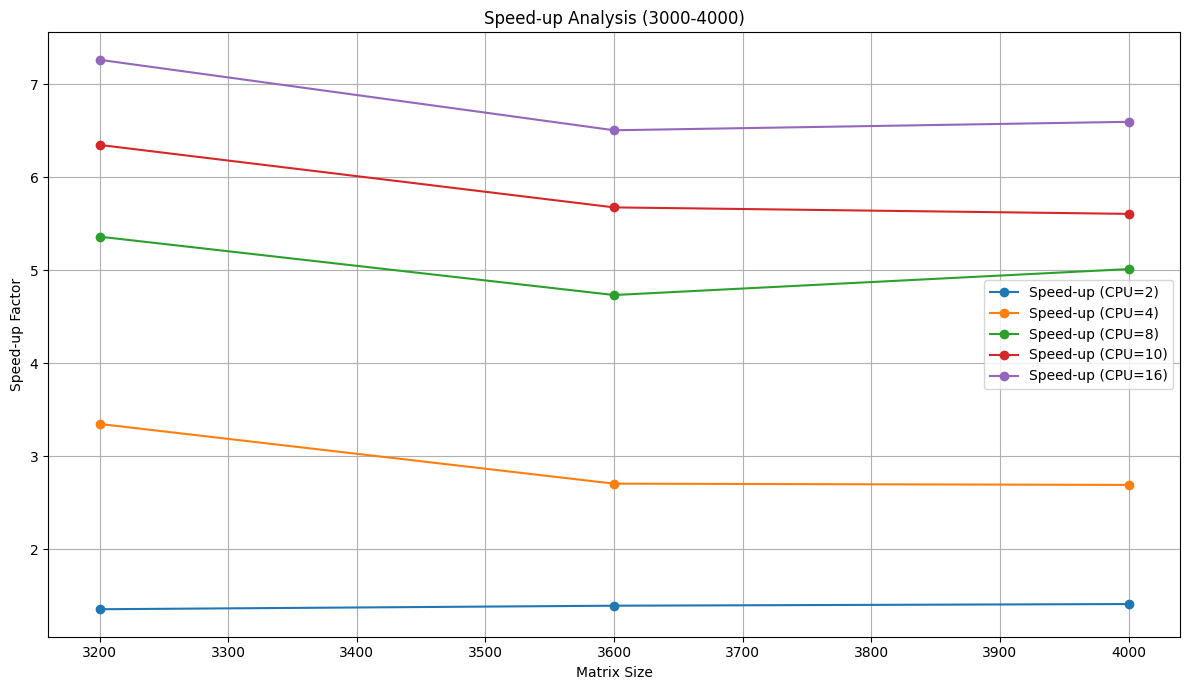

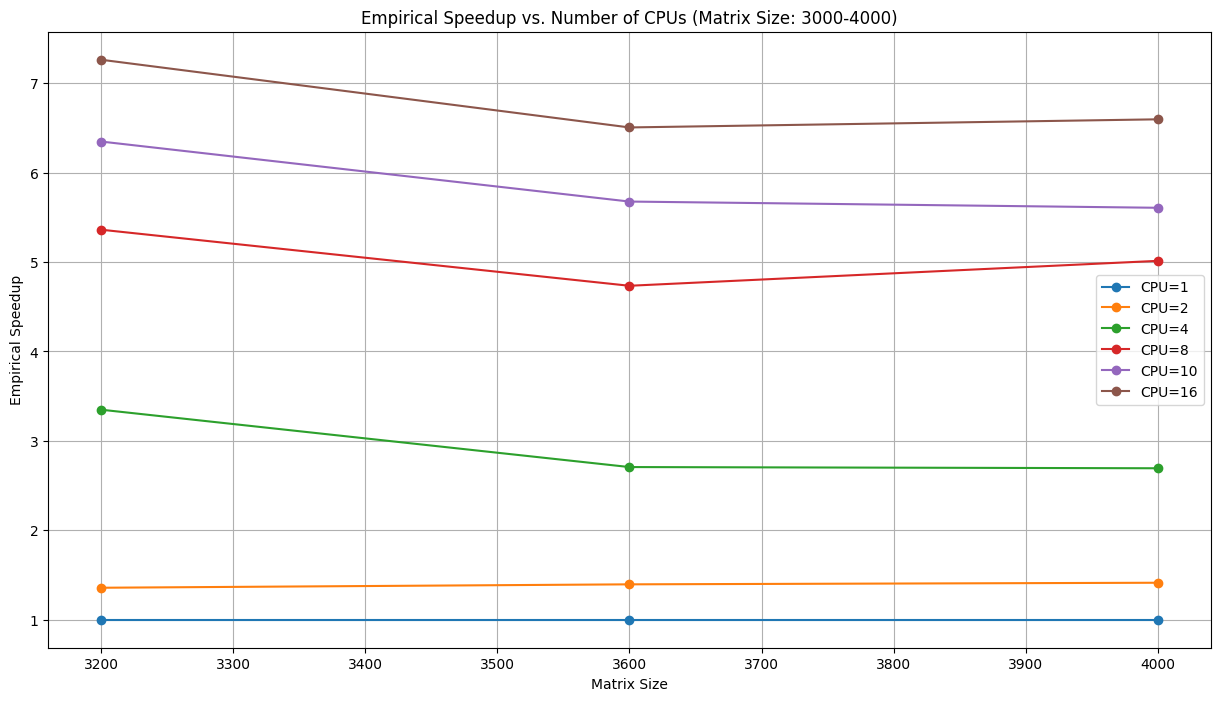

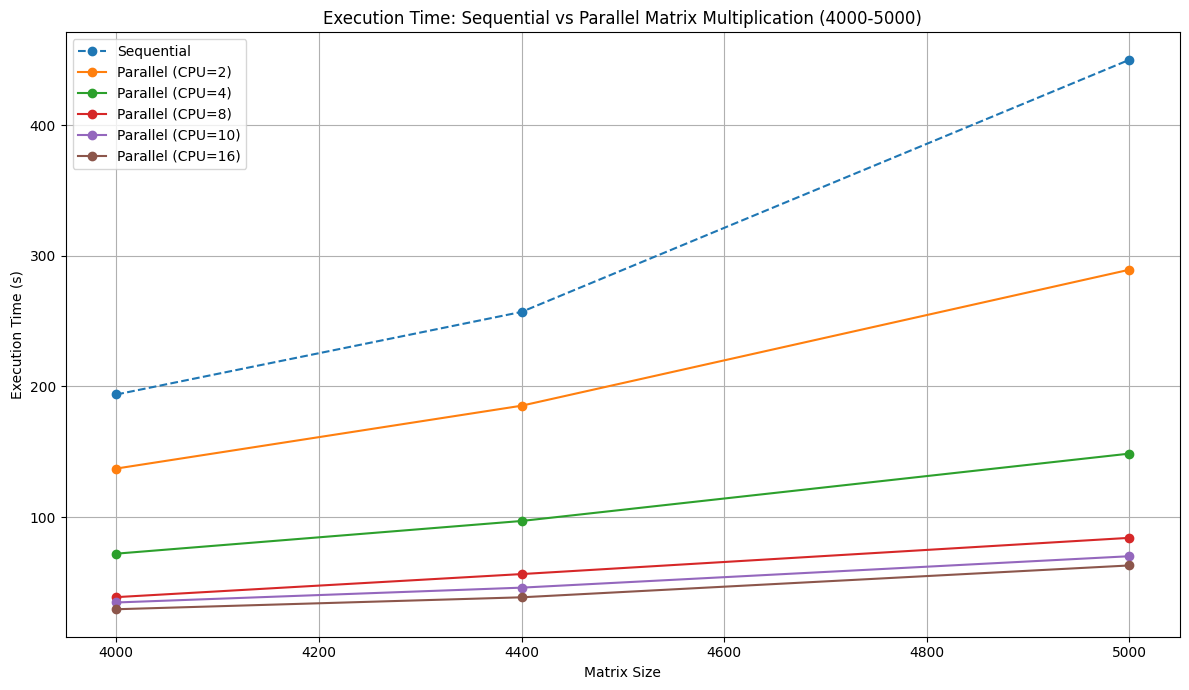

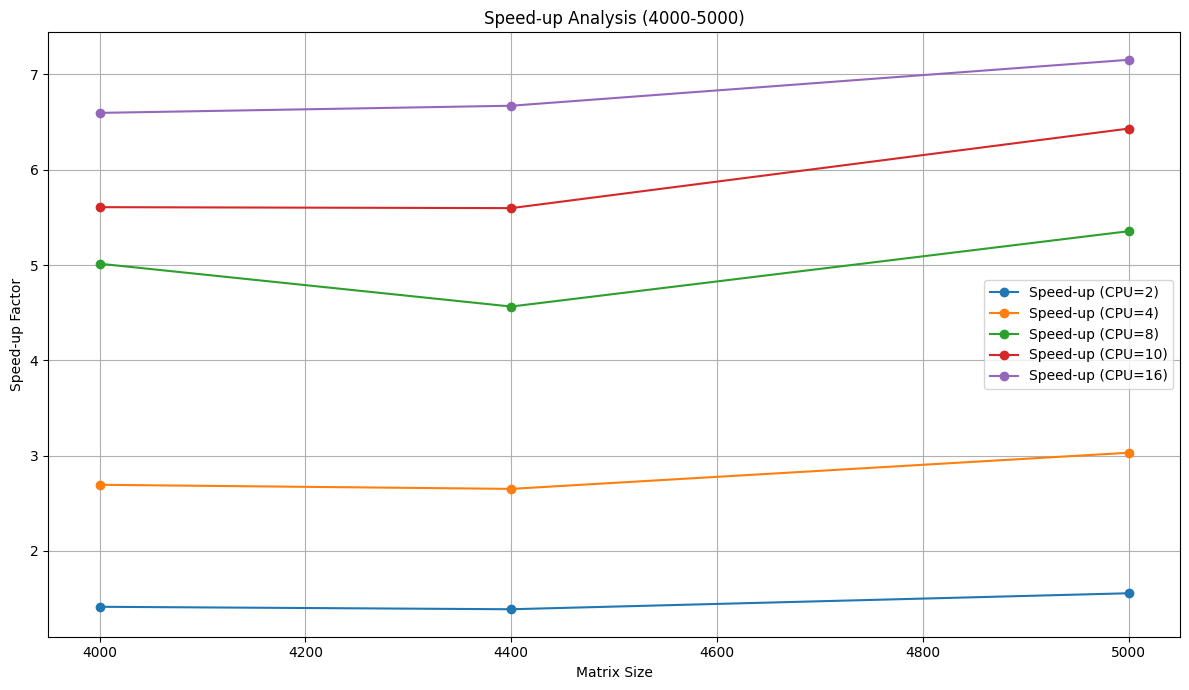

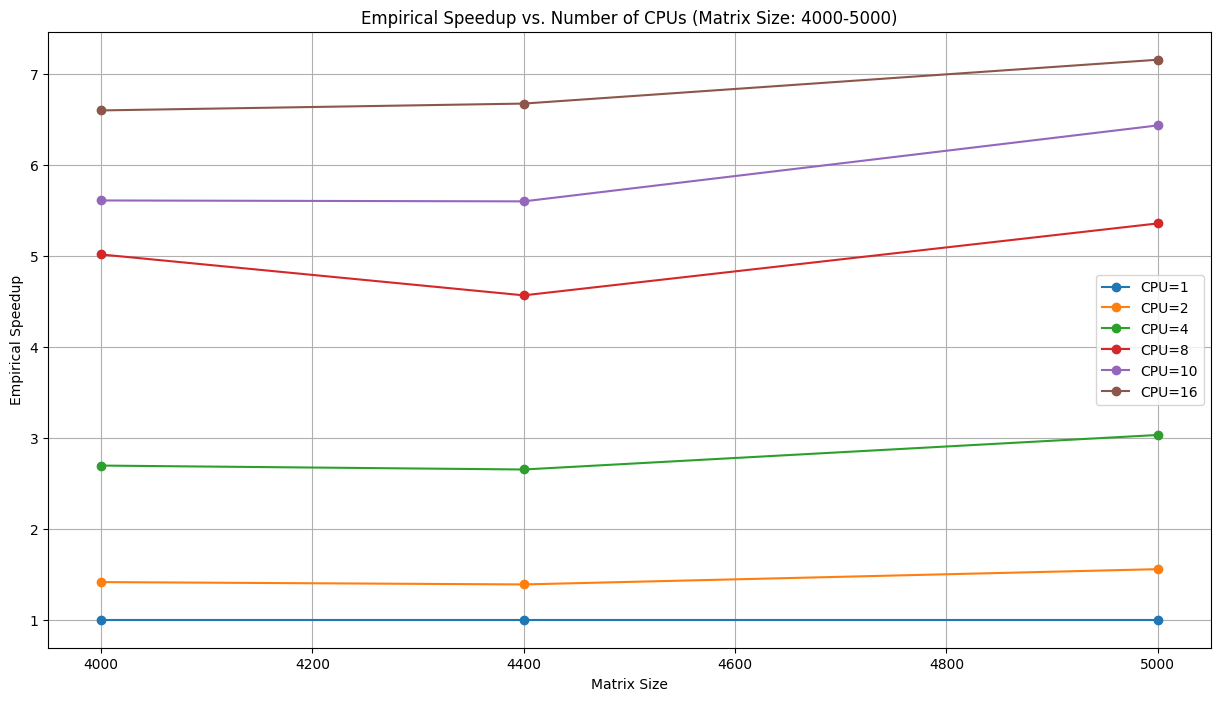

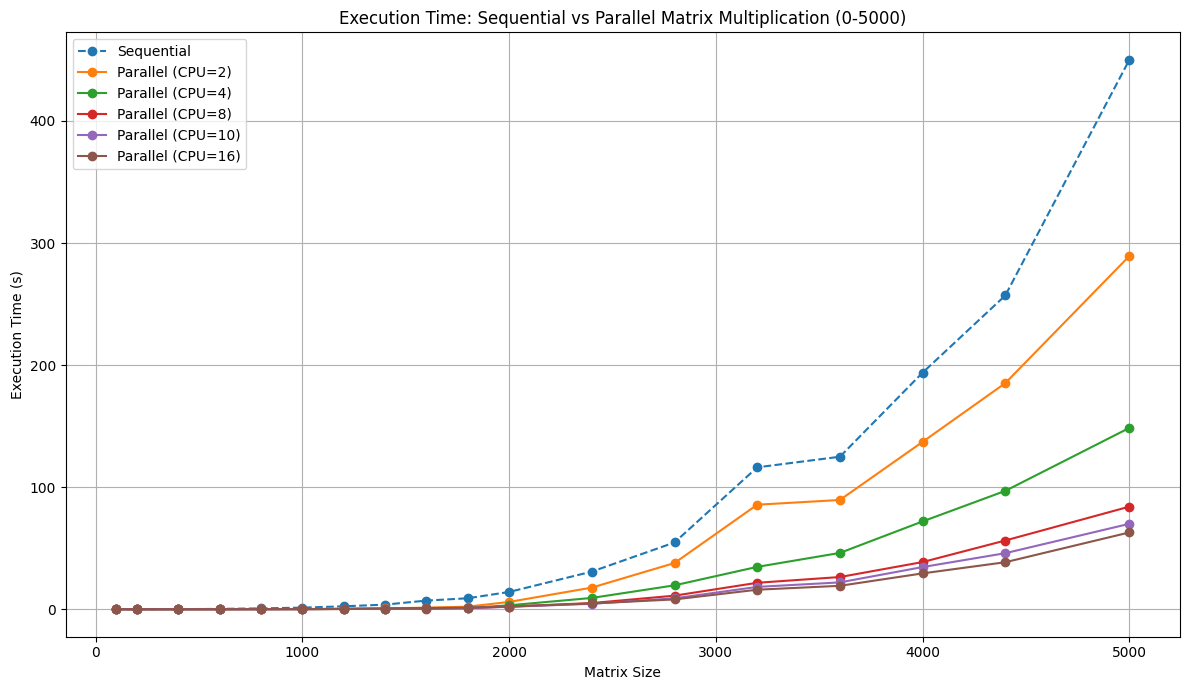

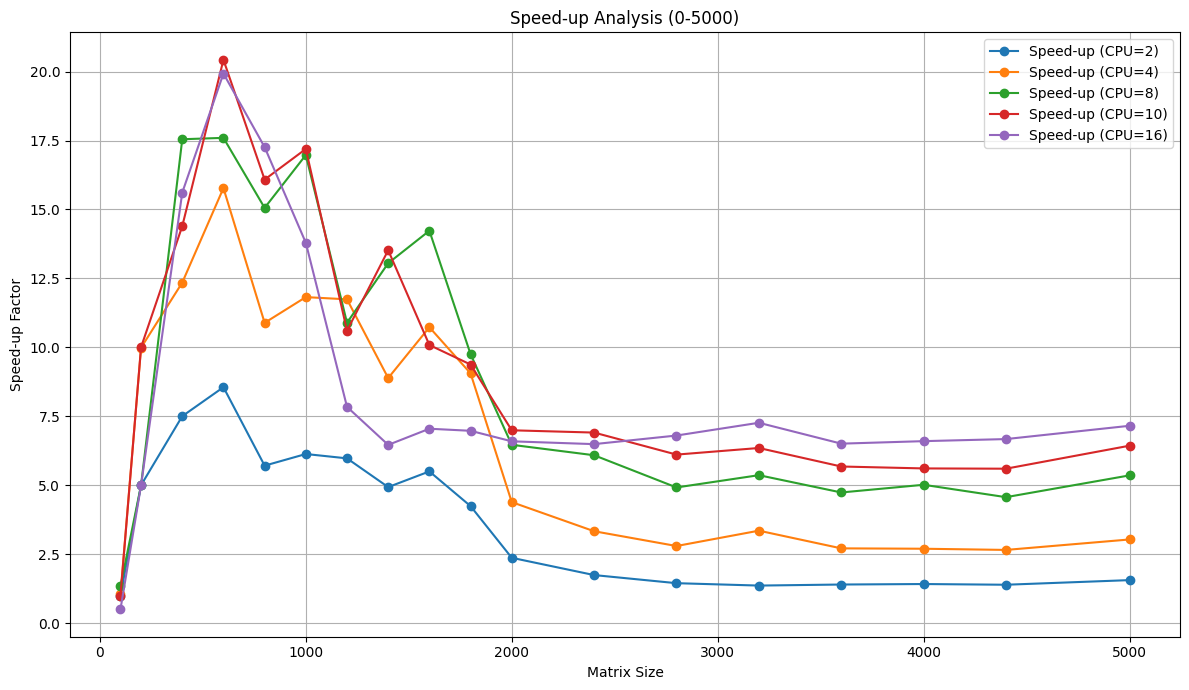

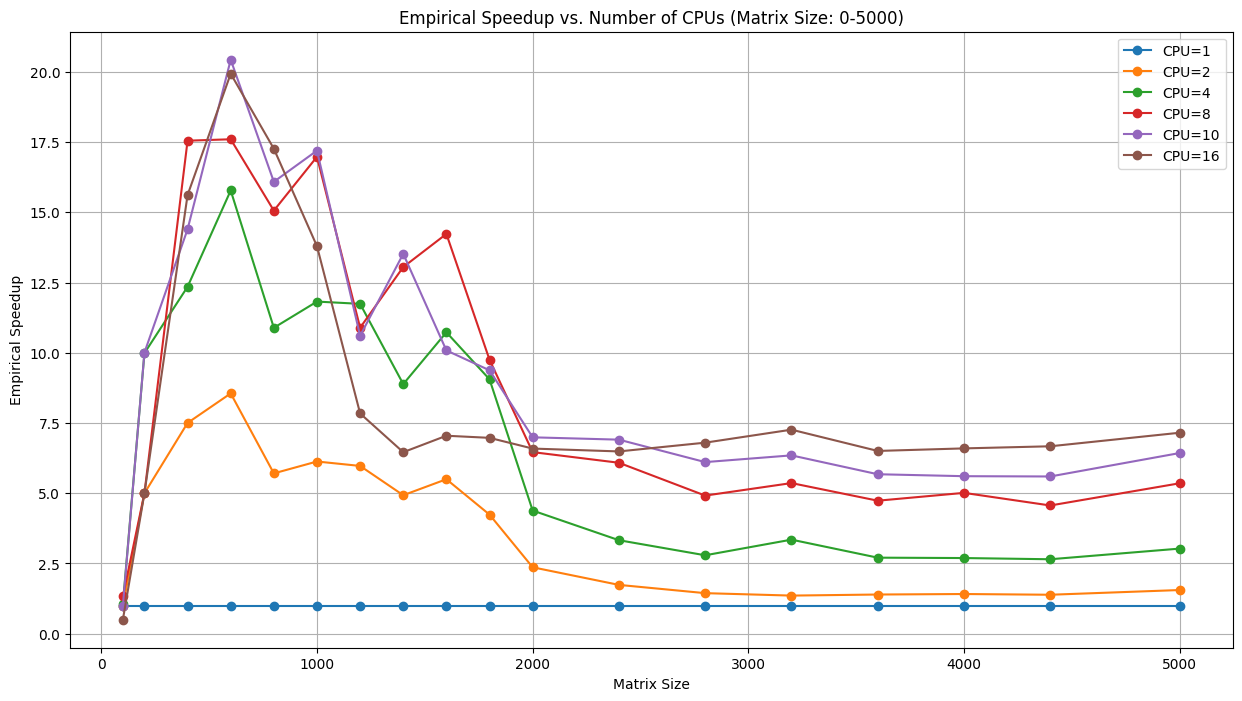

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
df = average_time_by_cpus_and_size.reset_index()
def plot_performance_by_size(df, size_range, cpu_counts):
    # Filter the DataFrame for the specified size range
    df_range = df[(df['size'] >= size_range[0]) & (df['size'] <= size_range[1])]

    # Plotting execution time for the size range
    plt.figure(figsize=(12, 7))
    for cpu in cpu_counts:
        # Compute the average time for each matrix size within the CPU count
        avg_time = df_range[df_range['cpus'] == cpu].groupby('size')['time'].mean()
        if cpu == 1:
            plt.plot(avg_time.index, avg_time.values, label=f'Sequential', linestyle='--', marker='o')
        else:
            plt.plot(avg_time.index, avg_time.values, label=f'Parallel (CPU={cpu})', marker='o')
    
    plt.xlabel('Matrix Size')
    plt.ylabel('Execution Time (s)')
    plt.title(f'Execution Time: Sequential vs Parallel Matrix Multiplication ({size_range[0]}-{size_range[1]})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting speed-up for the size range
    plt.figure(figsize=(12, 7))
    for cpu in cpu_counts:
        if cpu > 1:
            # Compute the average speedup for each matrix size within the CPU count
            avg_speedup = df_range[df_range['cpus'] == cpu].groupby('size')['speedup'].mean()
            plt.plot(avg_speedup.index, avg_speedup.values, label=f'Speed-up (CPU={cpu})', marker='o')

    plt.xlabel('Matrix Size')
    plt.ylabel('Speed-up Factor')
    plt.title(f'Speed-up Analysis ({size_range[0]}-{size_range[1]})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def plot_speedup_for_size_range(df, size_range):
    filtered_df = df[(df['size'] >= size_range[0]) & (df['size'] <= size_range[1])]
    cpu_counts = sorted(filtered_df['cpus'].unique())
    
    plt.figure(figsize=(15, 8))
    for cpu_count in cpu_counts:
        # Assuming there's a 'speedup' column already calculated
        subset = filtered_df[filtered_df['cpus'] == cpu_count]
        plt.plot(subset['size'], subset['speedup'], marker='o', label=f'CPU={cpu_count}')

    plt.title(f'Empirical Speedup vs. Number of CPUs (Matrix Size: {size_range[0]}-{size_range[1]})')
    plt.xlabel('Matrix Size')
    plt.ylabel('Empirical Speedup')
    plt.legend()
    plt.grid(True)
    plt.show()

df = pd.read_csv('C:\\Users\\spocam\\Desktop\\me.csv')
# Separate the sequential times
sequential_times = df[df['cpus'] == 1]

# Merge the sequential times back to calculate speedup
df = df.merge(sequential_times[['size', 'time']], on='size', suffixes=('', '_seq'))

# Calculate speedup
df['speedup'] = df['time_seq'] / df['time']

# Unique CPU counts
cpu_counts = sorted(df['cpus'].unique())

# Define size ranges
size_ranges = [(0, 500), (500, 1000), (1000,2000), (2000, 3000), (3000, 4000),(4000,5000),(0, 5000)]

# Plot for each size range
for size_range in size_ranges:
    plot_performance_by_size(df, size_range, cpu_counts)
    plot_speedup_for_size_range(df, size_range)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


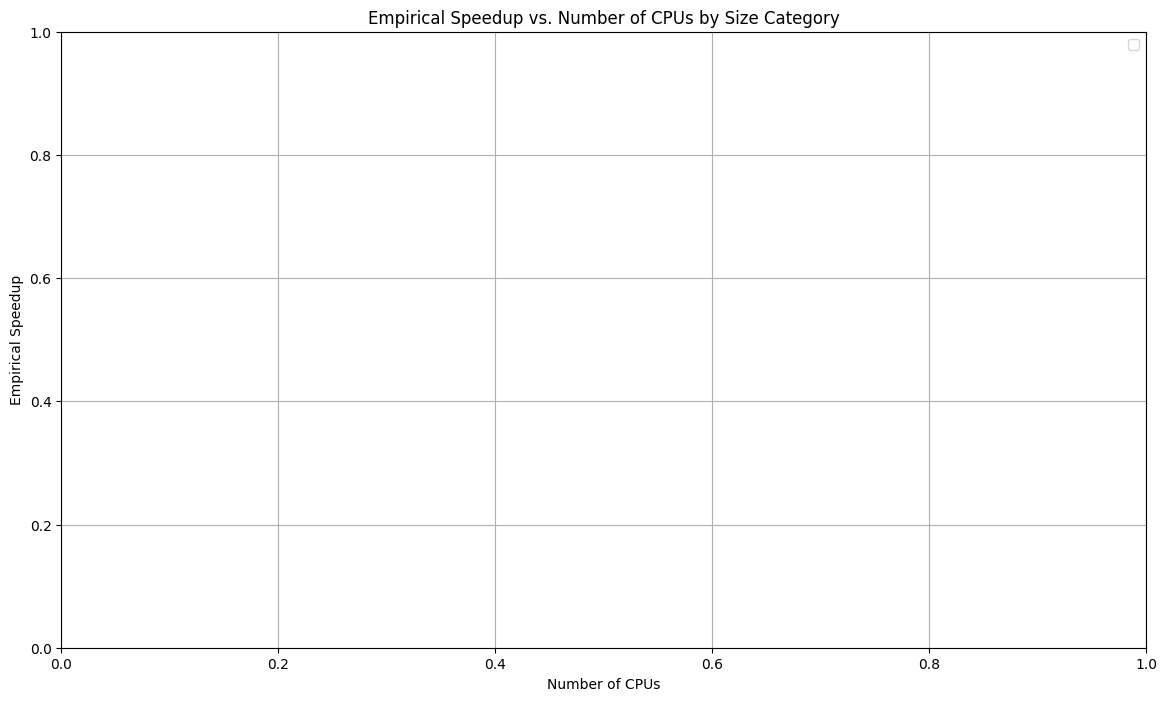

In [18]:
# Define bins and labels for the categorization
# Assuming 'df' is your main DataFrame and contains columns 'size' and 'empirical_speedup'
# Define bins and labels for the categorization
bins = [0, 500, 1000, 2000, 3000, 4000, 5000]
labels = ['0-500', '500-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000']

# Categorize sizes into bins
df['size_category'] = pd.cut(df['size'], bins=bins, labels=labels, right=False)

# Ensure the 'cpus' column exists and is formatted correctly in 'df'
# Assuming 'cpus' is also a column in 'df'
# Ensure 'empirical_speedup' is also a column in 'df'

plt.figure(figsize=(14, 8))

# Iterate over each category
for category in labels:
    subset = df[df['size'] == category]
    if not subset.empty:
        # Average speedup per CPU count within the category
        mean_speedup_per_cpu = subset.groupby('cpus')['speedup'].mean()
        plt.plot(mean_speedup_per_cpu.index, mean_speedup_per_cpu.values, label=f'Size {category}', marker='o')

plt.xlabel('Number of CPUs')
plt.ylabel('Empirical Speedup')
plt.title('Empirical Speedup vs. Number of CPUs by Size Category')
plt.legend()
plt.grid(True)
plt.show()


In [20]:

# Iterate through unique CPU counts
for cpu in sorted(df['cpus'].unique()):
    subset = df[df['cpus'] == cpu]
    min_speedup = subset['speedup'].min()
    max_speedup = subset['speedup'].max()
    min_size = subset[subset['speedup'] == min_speedup]['size'].iloc[0]
    max_size = subset[subset['speedup'] == max_speedup]['size'].iloc[0]

    print(f"For {cpu} CPUs:")
    print(f"• Speedup ranges from approximately {min_speedup:.2f} (for a {min_size}x{min_size} matrix) to {max_speedup:.2f} (for a {max_size}x{max_size} matrix).\n")


For 1 CPUs:
• Speedup ranges from approximately 1.00 (for a 100x100 matrix) to 1.00 (for a 100x100 matrix).

For 2 CPUs:
• Speedup ranges from approximately 0.99 (for a 100x100 matrix) to 8.55 (for a 600x600 matrix).

For 4 CPUs:
• Speedup ranges from approximately 1.05 (for a 100x100 matrix) to 15.78 (for a 600x600 matrix).

For 8 CPUs:
• Speedup ranges from approximately 1.33 (for a 100x100 matrix) to 17.60 (for a 600x600 matrix).

For 10 CPUs:
• Speedup ranges from approximately 0.99 (for a 100x100 matrix) to 20.43 (for a 600x600 matrix).

For 16 CPUs:
• Speedup ranges from approximately 0.50 (for a 100x100 matrix) to 19.93 (for a 600x600 matrix).



In [22]:
bins = [0, 500, 1000, 2000, 3000, 4000, 5000]  # Define your bins
labels = ['0-500', '500-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000']  # Labels for bins
df['size_category'] = pd.cut(df['size'], bins=bins, labels=labels, include_lowest=True)
cpu_counts = sorted(df['cpus'].unique())

# Iterate through each combination of CPU count and size category
for cpu in cpu_counts:
    print(f"For {cpu} CPUs:")
    for category in labels:
        subset = df[(df['cpus'] == cpu) & (df['size_category'] == category)]
        
        if subset.empty:
            continue  # Skip if there are no entries for this combination
        
        min_speedup = subset['speedup'].min()
        max_speedup = subset['speedup'].max()
        min_size = subset[subset['speedup'] == min_speedup]['size'].iloc[0]
        max_size = subset[subset['speedup'] == max_speedup]['size'].iloc[0]

        print(f"• In {category} matrix size range, speedup ranges from approximately {min_speedup:.2f} (for a {min_size}x{min_size} matrix) to {max_speedup:.2f} (for a {max_size}x{max_size} matrix).")

    print("\n")  # Add extra newline for readability between CPU counts


For 1 CPUs:
• In 0-500 matrix size range, speedup ranges from approximately 1.00 (for a 100x100 matrix) to 1.00 (for a 100x100 matrix).
• In 500-1000 matrix size range, speedup ranges from approximately 1.00 (for a 600x600 matrix) to 1.00 (for a 600x600 matrix).
• In 1000-2000 matrix size range, speedup ranges from approximately 1.00 (for a 1200x1200 matrix) to 1.00 (for a 1200x1200 matrix).
• In 2000-3000 matrix size range, speedup ranges from approximately 1.00 (for a 2400x2400 matrix) to 1.00 (for a 2400x2400 matrix).
• In 3000-4000 matrix size range, speedup ranges from approximately 1.00 (for a 3200x3200 matrix) to 1.00 (for a 3200x3200 matrix).
• In 4000-5000 matrix size range, speedup ranges from approximately 1.00 (for a 4400x4400 matrix) to 1.00 (for a 4400x4400 matrix).


For 2 CPUs:
• In 0-500 matrix size range, speedup ranges from approximately 0.99 (for a 100x100 matrix) to 7.50 (for a 400x400 matrix).
• In 500-1000 matrix size range, speedup ranges from approximately 5.71